In [ ]:
!pip install d2l==0.14.2

# **9.1 Gated Recurrent Units (GRU)**

9.1.1 Gated Hidden State

9.1.2 Implementation from Scratch

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [ ]:
def get_params(vocab_size, num_hiddens, device):
  num_inputs = num_outputs = vocab_size

  def normal(shape):
    return torch.randn(size=shape, device=device)*0.01
  
  def three():
    return (normal((num_inputs, num_hiddens)),
          normal((num_hiddens, num_hiddens)),
          torch.zeros(num_hiddens, device=device))

  W_xz, W_hz, b_z = three() # Update gate parameters
  W_xr, W_hr, b_r = three() # Reset gate parameters
  W_xh, W_hh, b_h = three() # Candidate hidden state parameters
  # Output layer parameters
  W_hq = normal((num_hiddens, num_outputs))
  b_q = torch.zeros(num_outputs, device=device)
  # Attach gradients
  params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
  for param in params:
    param.requires_grad_(True)
  return params

In [ ]:
def init_gru_state(batch_size, num_hiddens, device):
  return (torch.zeros((batch_size, num_hiddens), device=device), )

In [ ]:
def gru(inputs, state, params):
  W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
  H, = state
  outputs = []
  for X in inputs:
    Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
    R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
    H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
    H = Z * H + (1 - Z) * H_tilda
    Y = H @ W_hq + b_q
    outputs.append(Y)
  return torch.cat(outputs, dim=0), (H,)

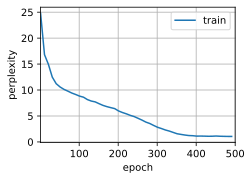

In [ ]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                            init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

9.1.3 Concise Implementation

In [ ]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = d2l.RNNModel(gru_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

# **9.2 Long Short-Term Memory (LSTM)**

9.2.1 Gated Memory Cell

9.2.2 Implementation from Scratch

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [22]:
def get_lstm_params(vocab_size, num_hiddens, device):
  num_inputs = num_outputs = vocab_size

  def normal(shape):
    return torch.randn(size=shape, device=device)*0.01

  def three():
    return (normal((num_inputs, num_hiddens)),
            normal((num_hiddens, num_hiddens)),
            torch.zeros(num_hiddens, device=device))
  W_xi, W_hi, b_i = three() # Input gate parameters
  W_xf, W_hf, b_f = three() # Forget gate parameters
  W_xo, W_ho, b_o = three() # Output gate parameters
  W_xc, W_hc, b_c = three() # Candidate memory cell parameters
  # Output layer parameters
  W_hq = normal((num_hiddens, num_outputs))
  b_q = torch.zeros(num_outputs, device=device)
  # Attach gradients
  params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc,
            b_c, W_hq, b_q]
  for param in params:
    param.requires_grad_(True)
  return params

In [23]:
def init_lstm_state(batch_size, num_hiddens, device):
  return (torch.zeros((batch_size, num_hiddens), device=device),
          torch.zeros((batch_size, num_hiddens), device=device))

In [25]:
def lstm(inputs, state, params):
  [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
  W_hq, b_q] = params
  (H, C) = state
  outputs = []
  for X in inputs:
    I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
    F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
    O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
    C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
    C = F * C + I * C_tilda
    H = O * torch.tanh(C)
    Y = (H @ W_hq) + b_q
    outputs.append(Y)
  return torch.cat(outputs, dim=0), (H, C)

perplexity 1.3, 15310.9 tokens/sec on cpu
time traveller whis the time traveller  it would extertive at th
traveller who said the medical man  easier fall the atore t


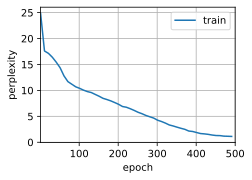

In [26]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
                            init_lstm_state, lstm)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

9.2.3 Concise Implementation

In [ ]:
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

# **9.3 Deep Recurrent Neural Networks**

9.3.1 Functional Dependencies

9.3.2 Concise Implementation

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
device = d2l.try_gpu()
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)

9.3.3 Training and Prediction

perplexity 1.0, 16396.3 tokens/sec on cpu
time traveller  it s against reason said filby  what reason said
traveller  it s against reason said filby  what reason said


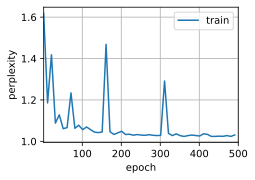

In [32]:
num_epochs, lr = 500, 2
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

# **9.4 Bidirectional Recurrent Neural Networks**

9.4.1 Dynamic Programming in Hidden Markov Models

9.4.2 Bidirectional Model

9.4.3 Training a Bidirectional RNN for a Wrong Application

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

# Load data
batch_size, num_steps, device = 32, 35, d2l.try_gpu()
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)
# Define the bidirectional LSTM model by setting `bidirectional=True`
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers, bidirectional=True)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
# Train the model
num_epochs, lr = 500, 1
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)